## we will be forecasting airline passengers using monthly airline passenger data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime 
from statsmodels.tsa.stattools import adfuller                
from statsmodels.tsa.seasonal import seasonal_decompose        
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX         
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error


In [2]:
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("airline-passengers.csv")
data.head()

,month,total_passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
# here we had described the descriptive statistics of data
data.describe()

,total_passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
#convert object dtype to datetime
data['Date']=pd.to_datetime(data['month'])

In [8]:
data.set_index('Date', inplace=True)

<Axes: xlabel='Date'>

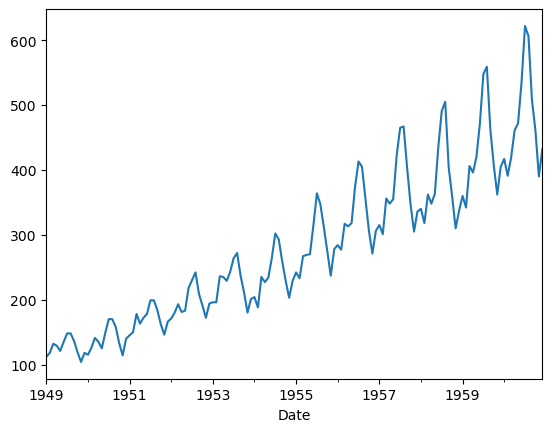

In [9]:
data['total_passengers'].plot()

### In this plot it is observed that their is increasing trend in data with passage of time. alongside trend values, increasing size of values are also observed.

In [10]:
data = data.drop(['month'], axis=1)

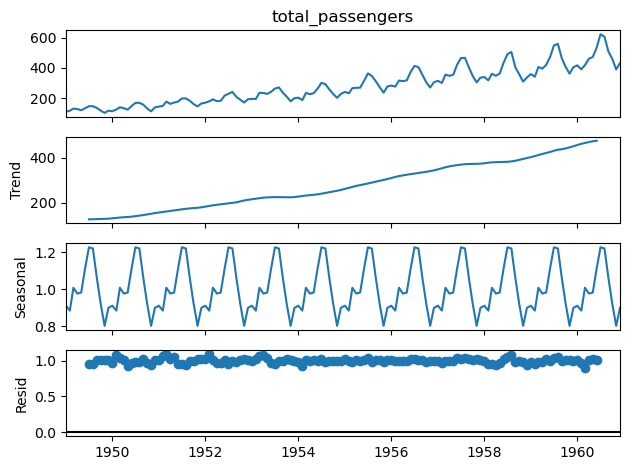

In [11]:
seasonal_decompose(data['total_passengers'], model='multilicative').plot();

### In the above plot when we decomposed data, seasonality is also observed in the data alongside trends.

In [12]:
print('Augmented Dickey-Fuller Test')
dftest = adfuller(data['total_passengers'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test


(0.8153688792060433,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

### Data is not stationary as P values of data is greater than 0.05, therefore we performed differencing of data to make it stationary.

In [13]:
diff1=data['total_passengers'].diff()
data1=pd.DataFrame(diff1)
data1=data1.dropna()
data1

,total_passengers
Date,
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0
1949-06-01,14.0
...,...
1960-08-01,-16.0
1960-09-01,-98.0
1960-10-01,-47.0


In [14]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data1['total_passengers'])
dftest

(-2.8292668241699865,
 0.05421329028382727,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854084)

### AS the data is still not stationary, we will again perform 2nd order differencing

In [15]:
data2=data1.diff()
data2=data2.dropna()
data2

,total_passengers
Date,
1949-03-01,8.0
1949-04-01,-17.0
1949-05-01,-5.0
1949-06-01,22.0
1949-07-01,-1.0
...,...
1960-08-01,-103.0
1960-09-01,-82.0
1960-10-01,51.0


In [16]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data2['total_passengers'])
dftest

(-16.384231542468495,
 2.7328918500143186e-29,
 11,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.6020417275607)

### Data became stationary after, 2nd order differencing, therefore d value will be 2.

### We will plot ACF and PACF plots to observe that which lag values are outside confidence interval.

<Figure size 800x400 with 0 Axes>

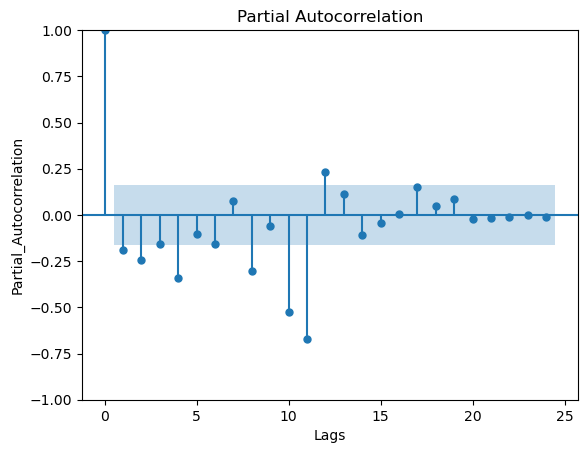

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot PACF
plt.figure(figsize=(8, 4))
plot_pacf(data2['total_passengers'], lags=24)  # Adjust 'lags' as needed
plt.xlabel('Lags')
plt.ylabel('Partial_Autocorrelation')
plt.show()

<Figure size 800x400 with 0 Axes>

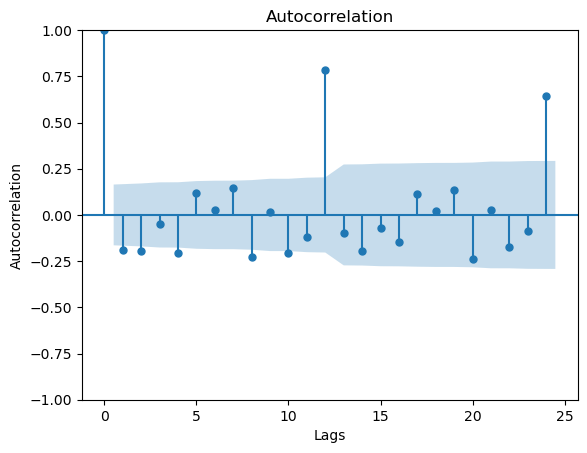

In [18]:
# Plot ACF
plt.figure(figsize=(8, 4))
plot_acf(data2['total_passengers'], lags=24)  # Adjust 'lags' as needed
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [19]:
len(data)

144

### We had splitted the data into train test dataset

In [20]:
train_data = data.iloc[:96]
test_data = data.iloc[96:]
len(test_data)

48

## As Seasonality is observed in the data, therefore SARIMAX model will be better choice for forecasting

In [38]:
#Fitting our model on Train set

model = SARIMAX(train_data['total_passengers'],order=(1,2,1),seasonal_order=(1,2,1, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   total_passengers   No. Observations:                   96
Model:             SARIMAX(1, 2, 1)x(1, 2, 1, 12)   Log Likelihood                -270.090
Date:                            Wed, 10 Jul 2024   AIC                            550.180
Time:                                    20:31:09   BIC                            561.422
Sample:                                01-01-1949   HQIC                           554.646
                                     - 12-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3565      0.126     -2.840      0.005      -0.602      -0.110
ma.L1         -0.9993      7.703     -0.130      0.897     -16.096      14.098
ar.S.L12      -0.3060      0.136     -2.251      0.024      -0.572      -0.040
ma.S.L12      -1.0000   1744.134     -0.001      1.000   -3419.439    3417.440
sigma2        77.8452   1.36e+05      0.001      1.000   -2.66e+05    2.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.03
Prob(Q):                              0.96   Prob(JB):                         0.60
Heteroskedasticity (H):               0.99   Skew:                             0.28
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
# Obtain predicted values

start=len(train_data)
end=len(train_data)+len(test_data)-1
predicted_data = results.predict(start=start, end=end,dynamic=False, typ='levels').rename('Predictions')

In [40]:
predicted_df = pd.DataFrame({'predicted passenger': predicted_data})
predicted_df['actual passenger']=test_data['total_passengers']
predicted_df.head()

,predicted passenger,actual passenger
1957-01-01,317.593709,315
1957-02-01,305.856095,301
1957-03-01,348.708511,356
1957-04-01,346.221702,348
1957-05-01,352.087425,355


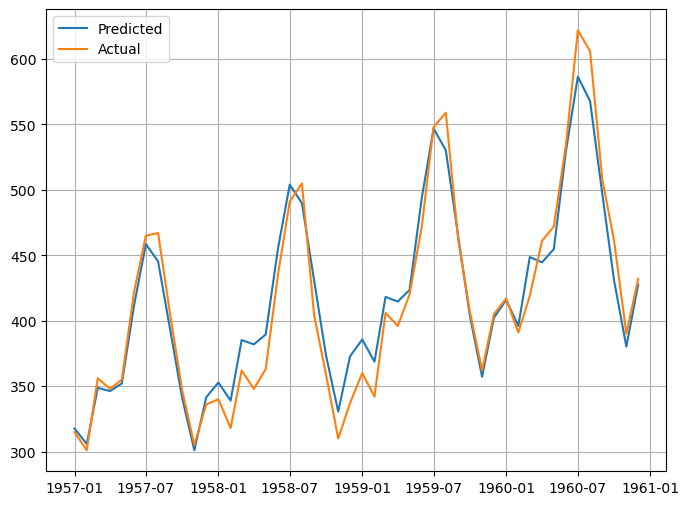

In [41]:
plt.figure(figsize=(8,6))
plt.plot(predicted_df['predicted passenger'])
plt.plot(predicted_df['actual passenger'])
plt.legend(['Predicted','Actual'])
plt.grid()
plt.show()

### This plots shows the predicted values of test data. from plot results it is observed that model has efficiently predicted the test data set

In [48]:
mae = mean_absolute_error(test_data['total_passengers'], predicted_data)
print("MAE Value is", mae)
mse = mean_squared_error(test_data['total_passengers'], predicted_data)
rmse = np.sqrt(mse)
print("\nRMSE Value is", rmse)
r2score = r2_score(test_data['total_passengers'], predicted_data)
print(f'\nR2 score value: {r2score}')

MAE Value is 14.633809453826741

RMSE Value is 18.219133558883225

R2 score value: 0.9449855018311138


### As R square value is 0.94, which means that model is well fitted on data. now we forcast the next month values using this model

In [49]:
start=len(data)
end=len(data)+24-1
forcasted_passengers= results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Forcasted Values')

## Now we will forecast the airline passenger values for next two years using this model

In [50]:
forcasted_data = pd.DataFrame({'Forecasted Passengers': forcasted_passengers})
forcasted_data.head(12)

,Forecasted Passengers
1961-01-01,442.198751
1961-02-01,419.292751
1961-03-01,474.921004
1961-04-01,470.299686
1961-05-01,481.636417
1961-06-01,561.953183
1961-07-01,621.713339
1961-08-01,600.696278
1961-09-01,523.753857
1961-10-01,452.510239


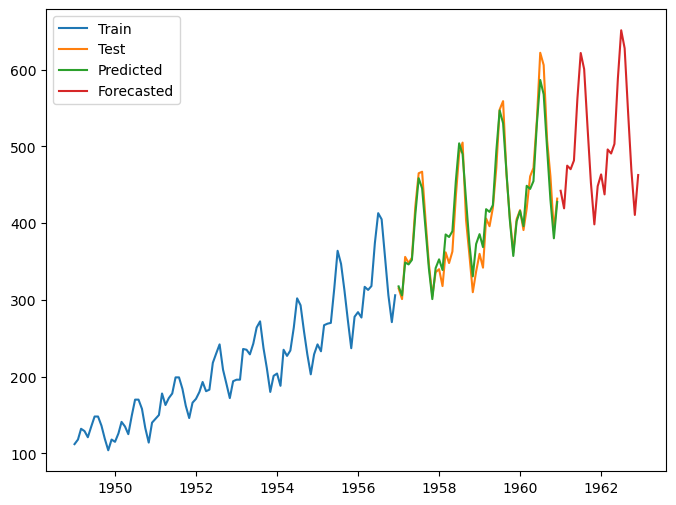

In [51]:
plt.figure(figsize=(8,6))
plt.plot(train_data['total_passengers'])
plt.plot(predicted_df['actual passenger'])
plt.plot(predicted_df['predicted passenger'])
plt.plot(forcasted_data['Forecasted Passengers'])
plt.legend(['Train','Test','Predicted','Forecasted'])
plt.show()

### In this plot we had plotted Train, Test, Predicted and Forcasted Results, Forecasted plot shows increasing trend with increase in step size, which shows that: with passage of time as population increases, theres will be increase in airline passengers